In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [3]:
class SMABacktester():
    def __init__(self, symbol, SMA_S, SMA_L, start, end):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prep_data()
        
    def get_data(self):
        raw = yf.download(self.symbol, self.start, self.end).Close.to_frame().dropna()
        raw.rename(columns = {"Close":"price"}, inplace=True)
        raw["returns"] = np.log(raw.price/raw.price.shift(1))
        self.data = raw.dropna()
     
    def prep_data(self):
        data = self.data.copy()
        data["SMA_S"] = data["price"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["price"].rolling(self.SMA_L).mean()
        self.data = data.dropna()
        
    def set_param(self, SMA_S = None, SMA_L=None):
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        data = self.data.copy()
        data["position"] = np.where(data["SMA_S"]>data["SMA_L"],1,-1)
        data["strategy"] = data["position"].shift(1)*data["returns"]
        data.dropna(inplace=True)
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1]
        outperf = perf - data["creturns"].iloc[-1]
        #self.data = data
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
    
    def opt_param(self, SMA_S_range, SMA_L_range):
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))
        
        results=[]
        for comb in combinations:
            self.set_param(comb[0], comb[1])
            results.append(self.test_strategy()[0])
            
        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]
        
        self.set_param(opt[0], opt[1])
        self.test_strategy()
        
        many_results = pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
        
        return opt, best_perf

In [4]:
tester = SMABacktester("^NSEBANK", 50, 200, "2010-01-01", "2023-6-21")

[*********************100%***********************]  1 of 1 completed


In [5]:
tester.data

price   returns         SMA_S         SMA_L
Date                                                          
2010-10-20  12176.500000 -0.005663  11710.926953   9942.930229
2010-10-21  12435.799805  0.021072  11751.069941   9959.148477
2010-10-22  12384.799805 -0.004109  11787.092930   9974.957476
2010-10-25  12424.700195  0.003217  11820.839941   9991.116226
2010-10-26  12332.650391 -0.007436  11853.881953  10006.975977
...                  ...       ...           ...           ...
2023-06-14  43988.000000 -0.002086  43133.007891  41631.693203
2023-06-15  43443.601562 -0.012453  43189.706953  41655.422969
2023-06-16  43938.148438  0.011319  43252.208906  41679.921211
2023-06-19  43633.750000 -0.006952  43304.900938  41703.336211
2023-06-20  43766.500000  0.003038  43359.410937  41727.232969

[2833 rows x 4 columns]

In [6]:
# tester.set_param(SMA_S=25, SMA_L=100)

In [7]:
tester.test_strategy()

(0.579386, -3.014956)

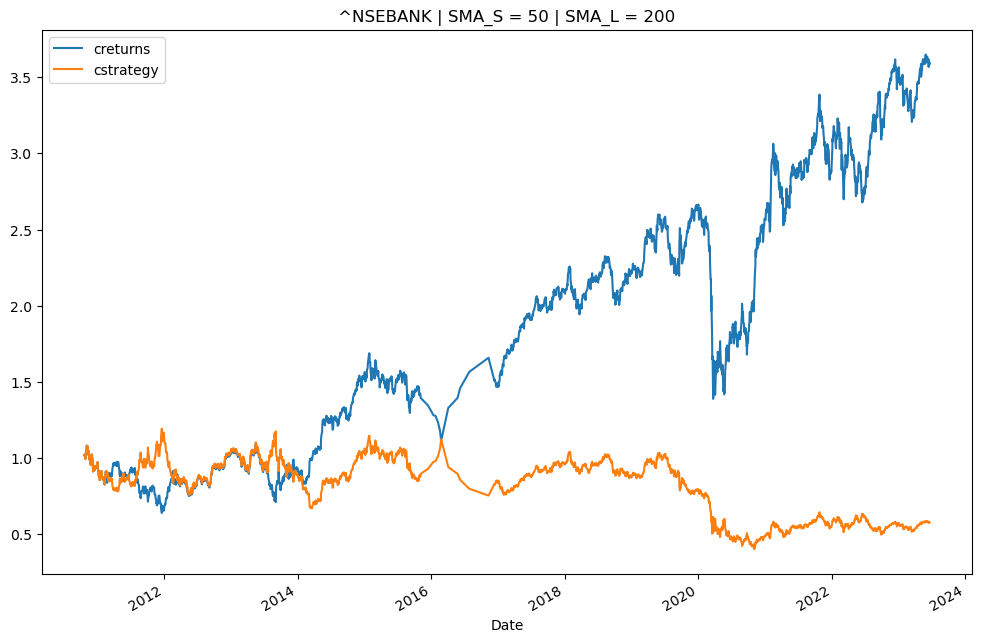

In [8]:
tester.plot_results()

In [9]:
tester.opt_param((20, 75, 1), (100, 200, 1))

((73, 155), 3.051667)

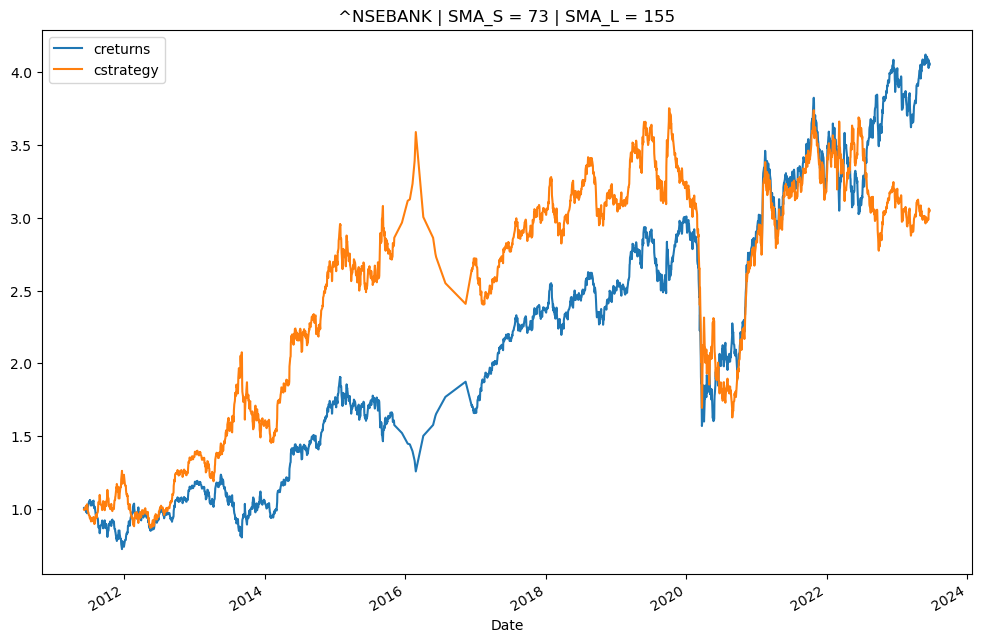

In [10]:
tester.plot_results()

In [11]:
tester.results_overview

SMA_S  SMA_L  performance
0        20    100     1.003260
1        20    101     0.942893
2        20    102     0.933392
3        20    103     0.926305
4        20    104     0.916104
...     ...    ...          ...
5495     74    195     1.072611
5496     74    196     1.156309
5497     74    197     0.939393
5498     74    198     0.841336
5499     74    199     0.701320

[5500 rows x 3 columns]

In [12]:
tester.results

price   returns         SMA_S         SMA_L  position  \
Date                                                                       
2011-06-06  10854.650391  0.006716  11088.057497  11334.792887        -1   
2011-06-07  10873.450195  0.001730  11084.478730  11326.386114        -1   
2011-06-08  10791.450195 -0.007570  11082.310921  11315.777407        -1   
2011-06-09  10785.400391 -0.000561  11078.684905  11305.458701        -1   
2011-06-10  10714.250000 -0.006619  11077.006140  11294.423538        -1   
...                  ...       ...           ...           ...       ...   
2023-06-14  43988.000000 -0.002086  42165.486890  42188.983191        -1   
2023-06-15  43443.601562 -0.012453  42213.900631  42204.807384         1   
2023-06-16  43938.148438  0.011319  42263.641000  42221.776739         1   
2023-06-19  43633.750000 -0.006952  42309.732770  42236.900605         1   
2023-06-20  43766.500000  0.003038  42351.764983  42253.802873         1   

            strategy  creturns  cstrategy  
Date                                       
2011-06-06 -0.006716  1.006738   0.993307  
2011-06-07 -0.001730  1.008482   0.991590  
2011-06-08  0.007570  1.000876   0.999124  
2011-06-09  0.000561  1.000315   0.999685  
2011-06-10  0.006619  0.993716   1.006323  
...              ...       ...        ...  
2023-06-14  0.002086  4.079763   2.991663  
2023-06-15  0.012453  4.029271   3.029152  
2023-06-16  0.011319  4.075139   3.063635  
2023-06-19 -0.006952  4.046907   3.042411  
2023-06-20  0.003038  4.059219   3.051667  

[2679 rows x 8 columns]